# Demo for linear inverse design of kirigami patterns with different deployment angle fields

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Structure import *
import Utils

In [2]:
def checkerboard(i, j):
    return Utils.is_even(i) + Utils.is_even(j) == 1


def build_contractibility_rows(m, n, toggle):
    mat = np.zeros(shape=(m*n, m*n + 2*(m+n)))

    array2linear = dict()
    linear2array = dict()    
    
    for i in range(-1, m+1):
        for j in range(-1, n+1):
            
            middle_ind = Utils.deployment_linkage2matrix(i, j, m, n)
            if middle_ind is not None:
                middle_ind = middle_ind[0]
                linear2array[middle_ind] = (i, j)
                array2linear[(i, j)] = middle_ind

            if 0 <= i < m and 0 <= j < n:  # bulk                

                if toggle:
                    white = checkerboard(i, j)
                else:
                    white = not checkerboard(i, j)

                if white:
                    left_ind, _ = Utils.deployment_linkage2matrix(i, j-1, m, n)                
                    right_ind, _ = Utils.deployment_linkage2matrix(i, j+1, m, n)
                else:
                    left_ind, _ = Utils.deployment_linkage2matrix(i-1, j, m, n)                
                    right_ind, _ = Utils.deployment_linkage2matrix(i+1, j, m, n)                        

                mat[middle_ind, middle_ind] = 2.0
                mat[middle_ind, left_ind] = 1.0
                mat[middle_ind, right_ind] = 1.0
                
    return mat, array2linear, linear2array

## Basic setup

In [3]:
# Pattern size
m, n = 3, 3

# Create a deployed matrix structure
structure = DeployedMatrixStructure(num_linkage_rows=m, num_linkage_cols=n)

left_mat, left_array2linear, left_linear2array = build_contractibility_rows(m, n, True)
right_mat, right_array2linear, right_linear2array = build_contractibility_rows(m, n, False)

mat = np.vstack([left_mat, right_mat])
array2linear = left_array2linear

left_mat_full = np.vstack([left_mat, np.zeros(shape=(2*(m+n), m*n + 2*(m+n)))])
for j in range(m*n, m*n+2*(m+n)):
    left_mat_full[j, j] = 1.0
    
constraint_b = 2*np.pi*np.ones(shape=(m*n, 1))

# ghost node for determining the boundary linkage angles
left_boundary_b = .6*np.pi*np.ones(shape=(m,1))
bottom_boundary_b = .15*np.pi*np.ones(shape=(n,1))
right_boundary_b = .7*np.pi*np.ones(shape=(m,1))
top_boundary_b = .2*np.pi*np.ones(shape=(n,1))

boundary_b = np.vstack([left_boundary_b, bottom_boundary_b, right_boundary_b, top_boundary_b])

left_mat_full_b = np.vstack([constraint_b, boundary_b])
left_mat_full_phis = np.linalg.solve(left_mat_full, left_mat_full_b).flatten()

# Use offset = 0 for all linkages
offset = 0.0
interior_offsets = np.array([[offset] * n] * m)
boundary_offset = 0.0
boundary_offsets = np.array([[boundary_offset] * m,
                             [boundary_offset] * n,
                             [boundary_offset] * m,
                             [boundary_offset] * n])

# set boundary point constraints for the linkage array
bound_linkage_inds = [structure.get_boundary_linkages(i) for i in range(4)]
bound_directions = np.array([[-1.0, 0.0], [0.0, -1.0], [1.0, 0.0], [0.0, 1.0]])
boundary_points = []
for i, bound in enumerate(bound_linkage_inds):
    local_boundary_points = []
    for j, linkage_ind in enumerate(bound):        
        p = structure.is_linkage_parallel_to_boundary(linkage_ind[0], linkage_ind[1], i)                
        if not p:
            point = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            local_boundary_points.append(point)
    boundary_points.append(np.vstack(local_boundary_points))
boundary_points = np.vstack(boundary_points)

# set 4 corner constraints for the pattern corner
corners = [[-1, 2], [-0.5, -4], [3, -4], [2.5, 2]] 
corners = np.vstack(corners)


## Example 1: a non-contractible kirigami pattern

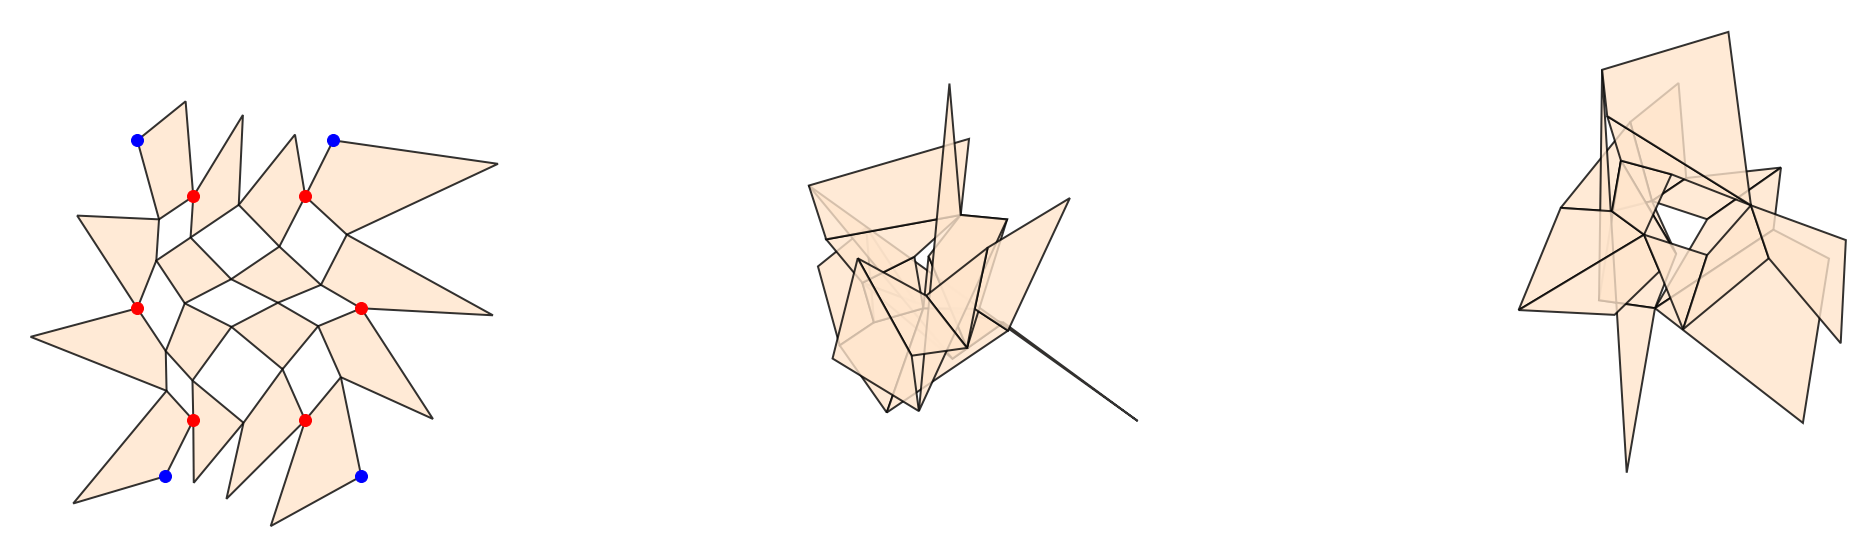

In [4]:
# set the deployment angle field arbitrarily
phis = np.array([[0.91314952, 1.74814161, 1.30153931],
        [0.9660656,  2.19464205, 2.22238692],
        [0.71640631, 1.50823398, 1.10984617]])

boundary_phis = np.array([[0.0] * m,
                          [0.0] * n,
                          [0.0] * m,
                          [0.0] * n], dtype=object)
for bound_ind in range(4):
    for z, (i, j) in enumerate(structure.get_outer_boundary_linkages(bound_ind)):
        boundary_phis[bound_ind][z] = np.pi - left_mat_full_phis[array2linear[(i, j)]]
        
# Use the linear inverse design method to generate a pattern
structure.linear_inverse_design(boundary_points=boundary_points,
                                corners=corners,
                                interior_offsets=interior_offsets,
                                boundary_offsets=boundary_offsets,
                                phis=phis,
                                boundary_phis=boundary_phis)

structure.assign_node_layers()
structure.assign_quad_genders()
structure.make_hinge_contact_points()

# plot the results
panel_size = 10
fig, axs = plt.subplots(1, 3, figsize=(1.2*panel_size*3, panel_size), sharey=True)

# plot the solved deployed structure
deployed_points = structure.points
plot_structure(deployed_points, structure.quads, structure.linkages, axs[0])
axs[0].plot(boundary_points[:, 0], boundary_points[:, 1], 'ro', ms=12)
axs[0].plot(corners[:, 0], corners[:, 1], 'bo', ms=12)

# the pattern does not admit a first closed and compact contracted state
# and so the contraction algorithm will fail and give an overlapping result
toggle = True
placed_points = structure.generic_layout(toggle)
placed_points[:,0] = placed_points[:,0] - (np.max(placed_points[:,0])+np.min(placed_points[:,0]))/2
placed_points[:,1] = placed_points[:,1] - (np.max(placed_points[:,1])+np.min(placed_points[:,1]))/2
plot_structure(placed_points, structure.quads, structure.linkages, axs[1])

# the pattern does not admit a second closed and compact contracted state
# and so the contraction algorithm will fail and give an overlapping result
toggle = False
placed_points2 = structure.generic_layout(toggle)
placed_points2[:,0] = placed_points2[:,0] - (np.max(placed_points2[:,0])+np.min(placed_points2[:,0]))/2
placed_points2[:,1] = placed_points2[:,1] - (np.max(placed_points2[:,1])+np.min(placed_points2[:,1]))/2
plot_structure(placed_points2, structure.quads, structure.linkages, axs[2])

# write_obj('Example_non-contractible_design.obj', deployed_points, structure.quads)

## Example 2: a contractible kirigami pattern

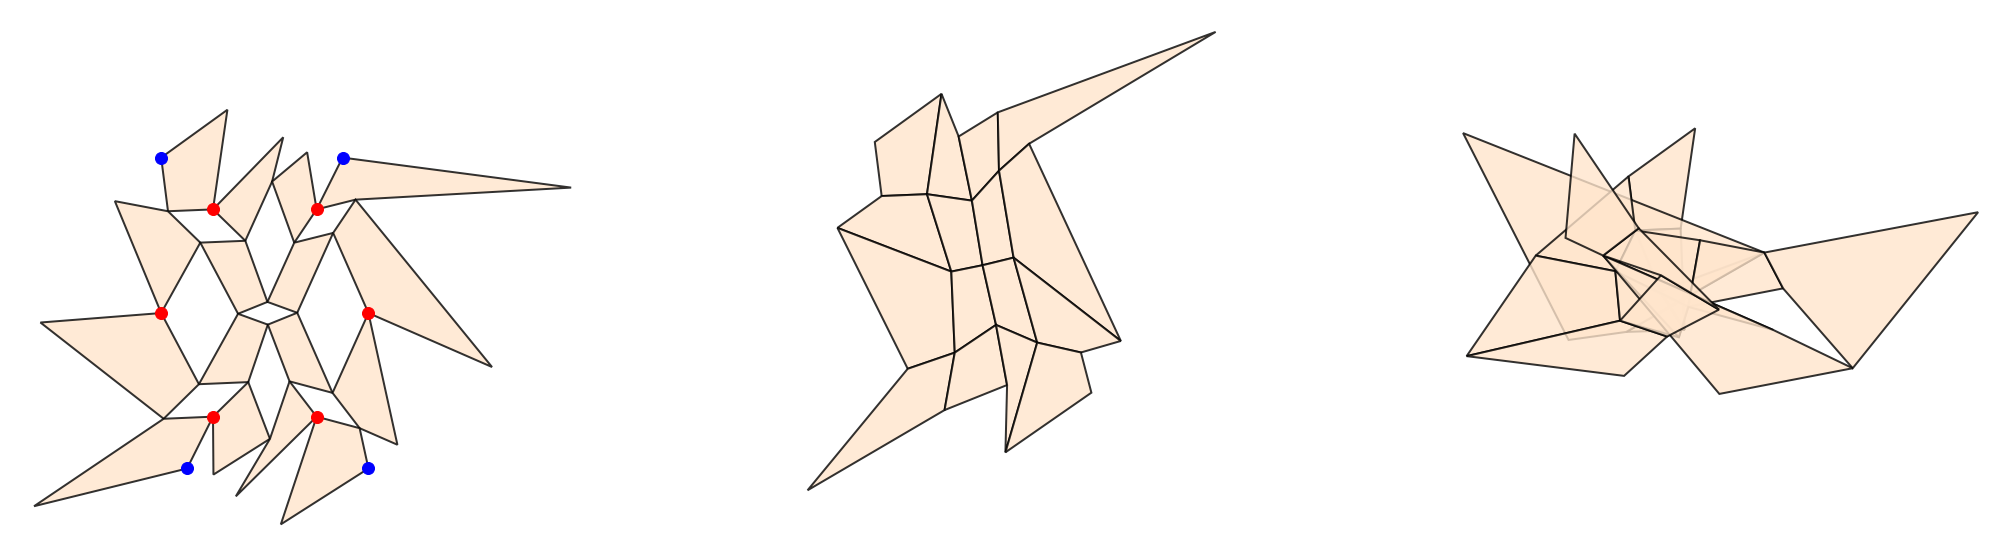

In [5]:
# set the deployment angle field based on the contractibility angle constraints

# Solve for contractible deployment angle field
designed_phis = left_mat_full_phis

boundary_phis = np.array([[0.0] * m,
                          [0.0] * n,
                          [0.0] * m,
                          [0.0] * n], dtype=object)
for bound_ind in range(4):
    for z, (i, j) in enumerate(structure.get_outer_boundary_linkages(bound_ind)):
        boundary_phis[bound_ind][z] = np.pi - designed_phis[array2linear[(i, j)]]


phis = np.zeros(interior_offsets.shape)
for i in range(m):
    for j in range(n):
        phis[i, j] = designed_phis[array2linear[(i, j)]]
        
# Use the linear inverse design method to generate a pattern
structure.linear_inverse_design(boundary_points=boundary_points,
                                corners=corners,
                                interior_offsets=interior_offsets,
                                boundary_offsets=boundary_offsets,
                                phis=phis,
                                boundary_phis=boundary_phis)

structure.assign_node_layers()
structure.assign_quad_genders()
structure.make_hinge_contact_points()

# plot the results
panel_size = 10
fig, axs = plt.subplots(1, 3, figsize=(1.2*panel_size*3, panel_size), sharey=True)

# plot the solved deployed structure
deployed_points = structure.points
plot_structure(deployed_points, structure.quads, structure.linkages, axs[0])
axs[0].plot(boundary_points[:, 0], boundary_points[:, 1], 'ro', ms=12)
axs[0].plot(corners[:, 0], corners[:, 1], 'bo', ms=12)

# plot the first closed and compact contracted state
toggle = True
placed_points = structure.generic_layout(toggle)
placed_points[:,0] = placed_points[:,0] - (np.max(placed_points[:,0])+np.min(placed_points[:,0]))/2
placed_points[:,1] = placed_points[:,1] - (np.max(placed_points[:,1])+np.min(placed_points[:,1]))/2
plot_structure(placed_points, structure.quads, structure.linkages, axs[1])

# the pattern does not admit a second closed and compact contracted state
# and so the contraction algorithm will fail and give an overlapping result
toggle = False
placed_points2 = structure.generic_layout(toggle)
placed_points2[:,0] = placed_points2[:,0] - (np.max(placed_points2[:,0])+np.min(placed_points2[:,0]))/2
placed_points2[:,1] = placed_points2[:,1] - (np.max(placed_points2[:,1])+np.min(placed_points2[:,1]))/2
plot_structure(placed_points2, structure.quads, structure.linkages, axs[2])

# write_obj('Example_contractible_design.obj', deployed_points, structure.quads)
# write_obj('Example_contractible_contracted.obj', placed_points, structure.quads)

## Example 3: a compact reconfigurable kirigami pattern

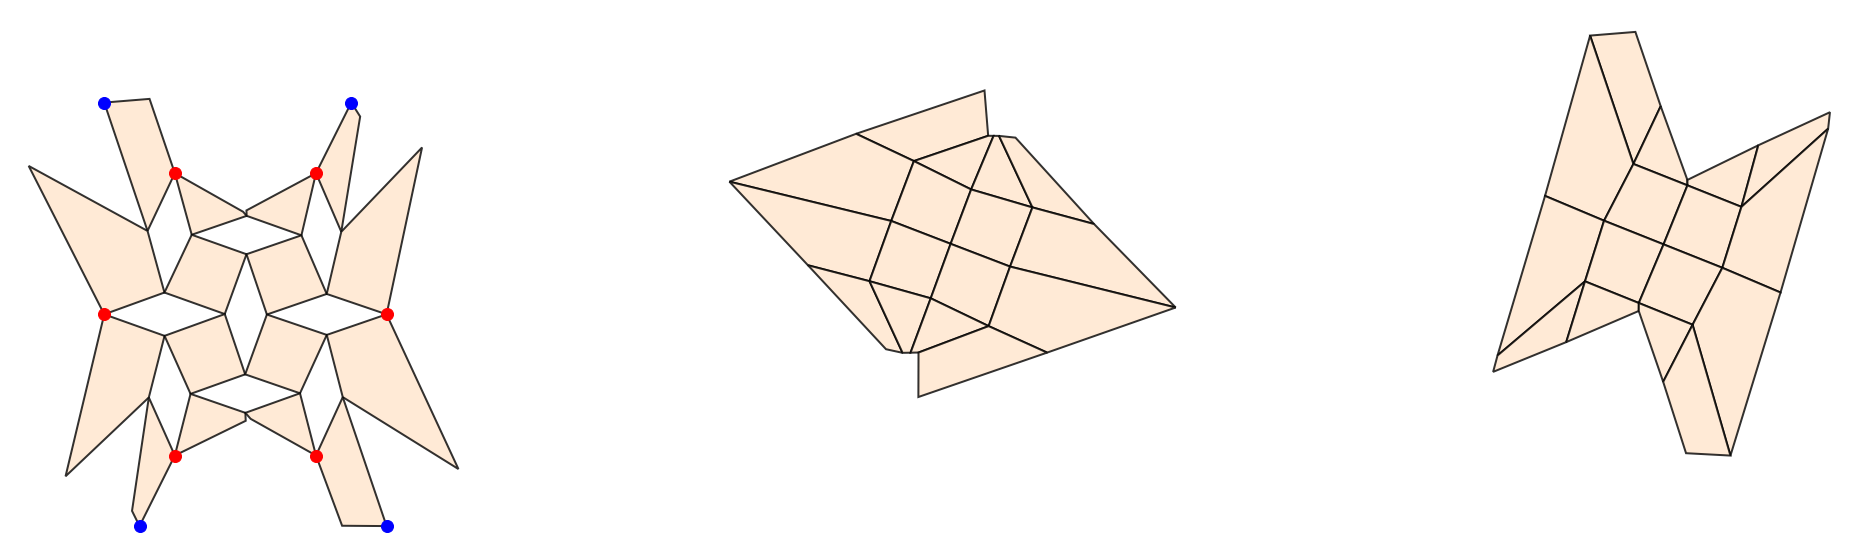

In [6]:
# set the deployment angle field based on the reconfigurability angle constraints

# attach right boundary constraints
right_bound_linear_inds = []
for i in range(m):
    for j in range(n):
        if i == 0 or j == 0 or i == m-1 or j == n-1:
            ind = right_array2linear[(i, j)]
            if ind not in right_bound_linear_inds:
                right_bound_linear_inds.append(ind)
mat_full = np.vstack([left_mat, right_mat[right_bound_linear_inds, :]])

# attach prescribed corners
right_corner_linear_inds = [right_array2linear[(0, 0)],
                            right_array2linear[(m-1, 0)],
                            right_array2linear[(m-1, n-1)],
                            right_array2linear[(0, n-1)]]

corner_mat = np.zeros(shape=(4, m*n + 2*(m+n)))
for i, ind in enumerate(right_corner_linear_inds):
    corner_mat[i, ind] = 1.0

mat_full = np.vstack([mat_full, corner_mat])
mat_full_b = np.vstack([2*np.pi*np.ones(shape=(m*n+2*(m+n)-4, 1)), 
                        np.pi*.2*np.ones(shape=(4,1))+(np.random.rand(4,1)*.2-.1)])
mat_full_phis = np.linalg.solve(mat_full, mat_full_b).flatten()

designed_phis = mat_full_phis

phis = np.zeros(interior_offsets.shape)
for i in range(m):
    for j in range(n):
        phis[i, j] = designed_phis[array2linear[(i, j)]]
        
boundary_phis = np.array([[0.0] * m,
                          [0.0] * n,
                          [0.0] * m,
                          [0.0] * n], dtype=object)
for bound_ind in range(4):
    for z, (i, j) in enumerate(structure.get_outer_boundary_linkages(bound_ind)):
        boundary_phis[bound_ind][z] = np.pi - designed_phis[array2linear[(i, j)]]

# Use the linear inverse design method to generate a pattern
structure.linear_inverse_design(boundary_points=boundary_points,
                                corners=corners,
                                interior_offsets=interior_offsets,
                                boundary_offsets=boundary_offsets,
                                phis=phis,
                                boundary_phis=boundary_phis)

structure.assign_node_layers()
structure.assign_quad_genders()
structure.make_hinge_contact_points()


# plot the results
panel_size = 10
fig, axs = plt.subplots(1, 3, figsize=(1.2*panel_size*3, panel_size), sharey=True)

# plot the solved deployed structure
deployed_points = structure.points
plot_structure(deployed_points, structure.quads, structure.linkages, axs[0])
axs[0].plot(boundary_points[:, 0], boundary_points[:, 1], 'ro', ms=12)
axs[0].plot(corners[:, 0], corners[:, 1], 'bo', ms=12)

# plot the first closed and compact contracted state
toggle = True
placed_points = structure.generic_layout(toggle)
placed_points = rotate_points(placed_points, np.array([0, 0]), -(np.pi)/2.0)
placed_points[:,0] = placed_points[:,0] - (np.max(placed_points[:,0])+np.min(placed_points[:,0]))/2
placed_points[:,1] = placed_points[:,1] - (np.max(placed_points[:,1])+np.min(placed_points[:,1]))/2
plot_structure(placed_points, structure.quads, structure.linkages, axs[1])

# plot the second closed and compact contracted state
toggle = False
placed_points2 = structure.generic_layout(toggle)
placed_points2[:,0] = placed_points2[:,0] - (np.max(placed_points2[:,0])+np.min(placed_points2[:,0]))/2
placed_points2[:,1] = placed_points2[:,1] - (np.max(placed_points2[:,1])+np.min(placed_points2[:,1]))/2
plot_structure(placed_points2, structure.quads, structure.linkages, axs[2])

# write_obj('Example_compact_reconfigurable_design.obj', deployed_points, structure.quads)
# write_obj('Example_compact_reconfigurable_contracted1.obj', placed_points, structure.quads)
# write_obj('Example_compact_reconfigurable_contracted2.obj', placed_points2, structure.quads)